# Noisy Deep Q-Network (Double DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

This is the implementation of the following paper https://arxiv.org/pdf/1706.10295.pdf


### 1. Import the Necessary Packages

In [9]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 #print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
 print("GPU RAM Free: {0:.2f}GB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.2f}GB".format(gpu.memoryFree/1024, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal/1024))
printm()

Gen RAM Free: 12.9 GB  | Proc size: 263.7 MB
GPU RAM Free: 11.17GB | Used: 0MB | Util   0% | Total 11.17GB


In [10]:
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb libav-tools xorg-dev python-opengl libboost-all-dev libsdl2-dev swig
!pip install pyvirtualdisplay
##!pip install piglet
!pip install pyglet==1.3.2  ###DONT CHANGE THE VERSION
!apt-get install xvfb
from pyvirtualdisplay import Display
!apt-get install cmake
!pip install setuptool
!pip install ez_setup
!pip install gym[atari] 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package libav-tools is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  ffmpeg

E: Package 'libav-tools' has no installation candidate
     |████████████████████████████████| 1.0MB 2.9MB/s 
  Found existing installation: pyglet 1.4.1
    Uninstalling pyglet-1.4.1:
      Successfully uninstalled pyglet-1.4.1
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 8 not upgraded.
Need to get 783 kB of archives.
After this operation, 2,266 kB of additional disk space will b

In [12]:
!pip install box2d-py
!pip install gym[Box_2D]
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


!pip -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

     |████████████████████████████████| 450kB 2.8MB/s 

Usage:   
  pip3 <command> [options]

no such option: -m


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


Define Environment

In [13]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.autograd import Variable

class NoisyLinear(nn.Module):
  def __init__(self, in_features, out_features, init_std =0.4):
    super(NoisyLinear, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.init_std = init_std
    self.training = True ## set this to false in the act method after the training is over
    
    self.weight_mu = nn.Parameter(torch.FloatTensor(out_features, in_features))
    self.weight_sigma = nn.Parameter(torch.FloatTensor(out_features, in_features))
    ## Adding noise to weight that will not be trained
    self.register_buffer('weight_epsilon',torch.FloatTensor(out_features, in_features) )
    
    self.bias_mu = nn.Parameter(torch.FloatTensor(out_features))
    self.bias_sigma = nn.Parameter(torch.FloatTensor(out_features))
    ## Adding noise to bias that will not be trained
    self.register_buffer('bias_epsilon',torch.FloatTensor(out_features) )   
    
    self.reset_parameter()  ##reset mu and sigma
    self.reset_noise()      ##reset epsilon
    
  def forward(self,X):
    if self.training:
      weight = self.weight_mu + self.weight_sigma.mul(Variable(self.weight_epsilon))
      bias = self.bias_mu + self.bias_sigma.mul(Variable(self.bias_epsilon))
    else:
      weight = self.weight_mu + self.weight_sigma
      bias = self.bias_mu + self.bias_sigma
      
    return F.linear(X, weight, bias)
  
  def reset_parameter(self):
    '''
    Initialize mu and sigma for weight and bias
    '''
    mu_range = 1/math.sqrt(self.in_features)
    self.weight_mu.data.uniform_(-mu_range, mu_range)
    self.bias_mu.data.uniform_(-mu_range, mu_range)
    
    self.weight_sigma.data.fill_(self.init_std*mu_range)
    self.bias_sigma.data.fill_(self.init_std*mu_range)
    
  def reset_noise(self):
    '''
    Generate noise for epsilon.
    These noise weights are not trainable by the model
    '''
    epsilon_out  = self.scale_noise(self.out_features)
    epsilon_in   = self.scale_noise(self.in_features)
    
    ##.ger() gives the matrix out of 2 vector numtiplication
    ## epsilon_out is out*1 
    ## epsilon_in is in*1
    ## the out of .ger() is out*in
    self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
    
    ## dont use the same random value for bias.
    ## call scale_coise once again for bias
    self.bias_epsilon.copy_(self.scale_noise(self.out_features))
    
    
  def scale_noise(self, size):
    '''
    Gives the noise output of a particular size after scaling
    '''
    
    
    X = torch.randn(size)
    X = X.sign().mul(X.abs().sqrt())
    return X
    
    
  

In [0]:
##Network


class QNetwork(nn.Module):
  """Actor (Policy) Model."""
  def __init__(self, state_size, action_size, seed,fc1_size =128, fc2_size=128):
    '''
    Initialize Parameters
    '''
    super(QNetwork, self).__init__()
    self.state_size = state_size
    self.action_size = action_size
    self.seed = torch.manual_seed(seed)
    self.FC1_size = fc1_size
    self.FC2_size = fc2_size
    self.FC1 = nn.Linear(self.state_size, self.FC1_size)
    #self.FC2 = nn.Linear(self.FC1_size, self.FC2_size)
    #self.FC3 = nn.Linear(self.FC2_size, self.action_size)
    
    self.noisy1 = NoisyLinear(self.FC1_size,self.FC2_size)
    self.noisy2 = NoisyLinear(self.FC2_size,action_size)
    
  
  def forward(self, state):
    """
    Build a network that maps state -> action values.
    """
    x = F.relu(self.FC1(state))
    x = F.relu(self.noisy1(x))
    x = self.noisy2(x)
    return x
  
  def reset_noise(self):
    
    self.noisy1.reset_noise()
    self.noisy2.reset_noise()

In [0]:
import numpy as np
import random
from collections import namedtuple, deque

import torch.optim as optim

##HYPERPARAMETERS

BUFFER_SIZE = int(1e5)  ##replay buffer size
BATCH_SIZE  = 128       ##minibatch size
GAMMA  = .99            ##discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
#LR = 1e-5  

UPDATE_EVERY = 4        ## how often local network gets copied to target network

if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

  


In [0]:
## Define the Replay Buffer ( Deque)

class ReplayBuffer:
  """
  Fixed-size buffer to store experience tuples.
  """
  def __init__(self,action_size, buffer_size, batch_size, seed):
    self.seed = random.seed(seed)
    self.buffer_size = buffer_size
    self.batch_size = batch_size
    self.action_size = action_size
    
    
    self.experience = namedtuple("Experience", field_names =["state", "actions","rewards","next_state", "done"])
    self.memory = deque(maxlen= buffer_size)
    
  def add(self, state, action,rewards, next_state, done):
      
    experience = self.experience(state, action,rewards,next_state, done)
    self.memory.append(experience)
      
  def sample(self):
    '''
    Randomly sample a batch from experience
    '''
      
    experiences = random.sample(self.memory,k = self.batch_size)
      
    state = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
    actions = torch.from_numpy(np.vstack([e.actions for e in experiences if e is not None])).long().to(device)  ## dont change to float
    rewards = torch.from_numpy(np.vstack([e.rewards for e in experiences if e is not None])).float().to(device)
    next_state = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
    done = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None])).float().to(device)
      
    return state,actions, rewards, next_state, done
  def __len__(self):
    """
    Return the current size of internal memory.
    """
    return len(self.memory)
  

    


In [0]:
## Define the Agent

class Agent():
  '''
  Interacts with and learns from the environment.
  '''
  def __init__(self,state_size,action_size, seed,batch_size= BATCH_SIZE,buffer_size= BUFFER_SIZE,lr=LR , gamma= GAMMA ):
    
    self.state_size = state_size
    self.action_size = action_size
    self.buffer_size = buffer_size
    self.batch_size = batch_size
    self.lr = lr
    self.gamma = gamma
    
    self.seed = random.seed(seed)
    
    # Q-Network
    self.qnetwork_local =  QNetwork(self.state_size, self.action_size, seed).to(device)
    self.qnetwork_target = QNetwork(self.state_size , self.action_size, seed).to(device)
    self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr= self.lr)
    self.criterion = nn.MSELoss()
    
    # Replay memory
    self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)
    # Initialize time step (for updating every UPDATE_EVERY steps)
    self.t_step = 0
  
  
  def step(self,state,actions,rewards, next_state,done):
    self.memory.add(state,actions,rewards, next_state,done)
    self.t_step =(self.t_step + 1)% UPDATE_EVERY
    ## dont learn whenever 1 batch is added.
    ##Rather wait for UPDATE_EVERY batch to be added before we call learn once
    if self.t_step==0:
      if len(self.memory)> self.batch_size:
        experiences = self.memory.sample()
        self.learn(experiences, self.gamma)
    
  def learn(self,experiences, gamma):
    """
    Update value parameters using given batch of experience tuples.
    """
    state, actions, rewards,next_state, done = experiences 
    target_q = self.qnetwork_target(next_state).detach()
    target_values = rewards + gamma*torch.max(target_q, 1)[0].unsqueeze(1)*(1-done)
    current_values= self.qnetwork_local(state).gather(1, actions)

    
    # Compute loss
    loss = self.criterion(current_values,target_values)
    
    
    ##optimization step
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    
    # ----- Update the target network -----
    if self.t_step==0:
      ## when it comes here self.t_step will always be 0 anyways. 
      ## So you may remove this if condition
      self.soft_update(self.qnetwork_local, self.qnetwork_target,TAU)
      
    self.qnetwork_local.reset_noise()
    self.qnetwork_target.reset_noise()
    
  def soft_update(self, qnetwork_local, qnetwork_target,tau):
    '''
    Update the target Q Network
    '''
    for local_parms, target_parms in zip(qnetwork_local.parameters(), qnetwork_target.parameters()):
      target_parms.data.copy_(tau*local_parms.data + (1.0 -tau)*target_parms.data)
        
        
  def act(self, state, epsilon =0.0):

    """
    Returns actions for given state as per current policy.
    """
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)

    self.qnetwork_local.eval()
    with torch.no_grad():
      actions_values = self.qnetwork_local(state)

    ##Back to train mode
    self.qnetwork_local.train()

    # Epsilon-greedy action selection

    if random.random() > epsilon:
      return np.argmax(actions_values.cpu().data.numpy())
    else:
      return np.random.choice(np.arange(self.action_size))
      
    

In [0]:
def dqn(n_episodes = 2000, max_t = 1000, eps_start = 1.0, eps_end = .01, eps_decay = 0.995, trained_score=200.0):
  scores =[]
  scores_window = deque(maxlen = 100)
  eps = eps_start
  
  for episode in range(1, n_episodes+1):
    state = env.reset()
    score = 0
    for t in range(max_t):
      action = agent.act(state,eps)
      next_state , rewards, done, _ = env.step(action)
      agent.step(state, action,rewards,next_state ,  done )
      state = next_state
      score += rewards
      if done:
        break
    scores_window.append(score)
    scores.append(score)
    eps = max(eps_end, eps*eps_decay)  ## reduce randomness epsilon as we learn
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)), end="")
    if episode % 100 == 0:
      print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
    ##if np.mean(scores_window)>=200.0:
    if np.mean(scores_window)>=trained_score:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode-100, np.mean(scores_window)))
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        break
  return scores
    
  


Episode 100	Average Score: -183.90
Episode 200	Average Score: -113.23
Episode 300	Average Score: -55.42
Episode 400	Average Score: 43.97
Episode 500	Average Score: 146.09
Episode 600	Average Score: 189.70
Episode 608	Average Score: 200.17
Environment solved in 508 episodes!	Average Score: 200.17


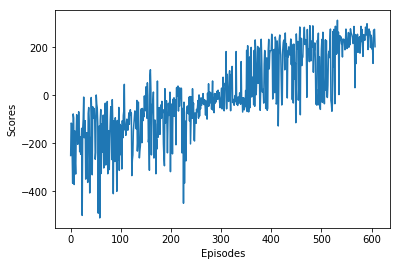

In [105]:
env_observation_space = 8
env_action_space = 4

agent = Agent(env_observation_space ,env_action_space, seed=0 )
scores = dqn()
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)) , scores)

plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.show()

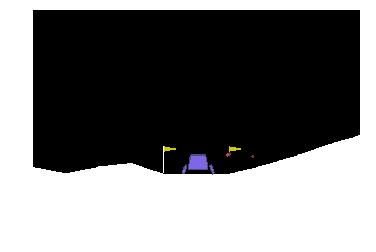

In [106]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(200):
        action = agent.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 
            


In [0]:
env.close()

CartPole-v0

In [0]:
##Environment states reshaped

In [0]:
import numpy as np
from collections import deque
import gym
from gym import spaces
import cv2
cv2.ocl.setUseOpenCL(False)

class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def reset(self):
        return self.env.reset()

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255,
            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[0], shp[1], shp[2] * k), dtype=np.uint8)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=2)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

def make_atari(env_id):
    env = gym.make(env_id)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    return env

def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env



class ImageToPyTorch(gym.ObservationWrapper):
    """
    Image shape to num_channels x weight x height
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.uint8)

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)
    

def wrap_pytorch(env):
    return ImageToPyTorch(env)

In [0]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [0]:
env.observation_space.shape

(1, 84, 84)

In [0]:
env.observation_space.shape[0]

1

I have made some minor changes to deal with the state which is fed into conv Layer.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
  """Actor (Policy) Model."""
  def __init__(self, state_size, action_size, seed,):
    '''
    Initialize Parameters
    '''
    super(QNetwork, self).__init__()
    self.state_size = state_size
    self.action_size = action_size
    
    self.features = nn.Sequential(
            nn.Conv2d(self.state_size[0], 32, kernel_size=8, stride =4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride =2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride =1),
            nn.ReLU()
    )
    
    self.noisy1 = NoisyLinear(3136, 512)
    self.noisy2 = NoisyLinear(512, self.action_size)
    
  
  def forward(self, state):
    """
    Build a network that maps state -> action values.
    """
    
    #print('$$',state.shape)
    x = self.features(state)
    x = x.reshape(state.shape[0],-1)
    ##print('--',x.shape)
    
    
    x = F.relu(self.noisy1(x))
    x = self.noisy2(x)
    return x
  
  def feature_size(self):
    return self.features(autograd.Variable(torch.zeros(1, *self.state_size))).view(1, -1).size(1)

In [0]:
## Define the Replay Buffer ( Deque)

class ReplayBuffer:
  """
  Fixed-size buffer to store experience tuples.
  """
  def __init__(self,action_size, buffer_size, batch_size, seed):
    self.seed = random.seed(seed)
    self.buffer_size = buffer_size
    self.batch_size = batch_size
    self.action_size = action_size
    
    
    self.experience = namedtuple("Experience", field_names =["state", "actions","rewards","next_state", "done"])
    self.memory = deque(maxlen= buffer_size)
    
  def add(self, state, action,rewards, next_state, done):
    
    
    
    ##print('**',state.shape)
    state = np.expand_dims(state, axis=0)
    next_state = np.expand_dims(next_state, axis=0)
    ##print('**',state.shape)
    
      
    experience = self.experience(state, action,rewards,next_state, done)
    ##print('12',experience.state.shape)
    self.memory.append(experience)
      
  def sample(self):
    '''
    Randomly sample a batch from experience
    '''
      
    experiences = random.sample(self.memory,k = self.batch_size)
      
    state = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
    actions = torch.from_numpy(np.vstack([e.actions for e in experiences if e is not None])).long().to(device)  ## dont change to float
    rewards = torch.from_numpy(np.vstack([e.rewards for e in experiences if e is not None])).float().to(device)
    next_state = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
    done = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None])).float().to(device)
    
    #print('34',state.shape)
      
    return state,actions, rewards, next_state, done
  def __len__(self):
    """
    Return the current size of internal memory.
    """
    return len(self.memory)
    


In [0]:
## Define the Agent

class Agent():
  '''
  Interacts with and learns from the environment.
  '''
  def __init__(self,state_size,action_size, seed,batch_size= BATCH_SIZE,buffer_size= BUFFER_SIZE,lr=LR , gamma= GAMMA ):
    
    self.state_size = state_size
    self.action_size = action_size
    self.buffer_size = buffer_size
    self.batch_size = batch_size
    self.lr = lr
    self.gamma = gamma
    
    self.seed = random.seed(seed)
    
    # Q-Network
    self.qnetwork_local =  QNetwork(self.state_size, self.action_size, seed).to(device)
    self.qnetwork_target = QNetwork(self.state_size , self.action_size, seed).to(device)
    self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr= self.lr)
    self.criterion = nn.MSELoss()
    
    # Replay memory
    self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)
    # Initialize time step (for updating every UPDATE_EVERY steps)
    self.t_step = 0
  
  
  def step(self,state,actions,rewards, next_state,done):
    self.memory.add(state,actions,rewards, next_state,done)
    self.t_step =(self.t_step + 1)% UPDATE_EVERY
    ## dont learn whenever 1 batch is added.
    ##Rather wait for UPDATE_EVERY batch to be added before we call learn once
    if self.t_step==0:
      if len(self.memory)> self.batch_size:
        experiences = self.memory.sample()
        self.learn(experiences, self.gamma)
    
  def learn(self,experiences, gamma):
    """
    Update value parameters using given batch of experience tuples.
    """
    state, actions, rewards,next_state, done = experiences 
    
    ##print(target_q.shape)
    
    #Double DQN
    
    current_values= self.qnetwork_local(state).gather(1, actions)
    #print('current_values',current_values.shape)
    target_q = self.qnetwork_local(next_state)
    #print(target_q.shape)
    #target_q = torch.max(target_q, 1)[1].unsqueeze(1) #get the indices same as argmax
    target_q = torch.max(target_q, 1)[1].unsqueeze(1)
    #print('actions',actions.shape)
    #print('target_q',target_q.shape)
    #print(target_q.shape)
    target_values = rewards + gamma*self.qnetwork_target(next_state).gather(1, target_q)*(1-done)
    
    
    # Compute loss
    loss = self.criterion(current_values,target_values)
    
    ##optimization step
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    
    # ----- Update the target network -----
    if self.t_step==0:
      ## when it comes here self.t_step will always be 0 anyways. 
      ## So you may remove this if condition
      self.soft_update(self.qnetwork_local, self.qnetwork_target,TAU)
    
  def soft_update(self, qnetwork_local, qnetwork_target,tau):
    '''
    Update the target Q Network
    '''
    for local_parms, target_parms in zip(qnetwork_local.parameters(), qnetwork_target.parameters()):
      target_parms.data.copy_(tau*local_parms.data + (1.0 -tau)*target_parms.data)
        
        
  def act(self, state, epsilon =0.0):

    """
    Returns actions for given state as per current policy.
    """
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)

    self.qnetwork_local.eval()
    with torch.no_grad():
      actions_values = self.qnetwork_local(state.to(device))

    ##Back to train mode
    self.qnetwork_local.train()

    # Epsilon-greedy action selection

    if random.random() > epsilon:
      return np.argmax(actions_values.cpu().data.numpy())
    else:
      return np.random.choice(np.arange(self.action_size))
      
    

In [0]:
import torch.autograd as autograd 

agent = Agent(env.observation_space.shape ,env.action_space.n, seed=0 )

scores = dqn(n_episodes = 1400000, max_t = 1000, eps_start = 1.0, eps_end = .01, eps_decay = 0.995, trained_score=15.0)
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)) , scores)

plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.show()

Episode 100	Average Score: -16.25
Episode 200	Average Score: -18.67
Episode 214	Average Score: -18.42